In [9]:
from pathlib import Path
import random
import os
import re

import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt

from simple_dataloader import create_dataloader

In [2]:
def set_seed(seed):
    """
    Sets the random seed for reproducibility.
    Args:
        seed (int): The seed value to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    print("CUDA is available. Using GPU")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU


## Data

In [4]:
data_path = Path('data/ben_bucket')
pcaps = data_path.glob('**/*.pcap')
pcap_paths = pd.Series(pcaps)

In [5]:
def extract_pcap_info(path):
    p = Path(path)
    parts = p.parts
    location = parts[3]  # 4th part (traffic/location/date...)
    date_str = parts[4]  # 5th part is the date
    app = parts[5]       # 6th part is the app
    vpn_type = parts[6]   # 7th part is VPN/Non-VPN

    date = pd.to_datetime(date_str, format='%Y%m%d_%H%M%S')
    
    return location, date, app, vpn_type

# Apply the function to each path in the series
df = pd.DataFrame(pcap_paths.apply(extract_pcap_info).tolist(), columns=['location', 'date', 'app', 'vpn_type'])
df['pcap_path'] = pcap_paths

In [6]:
# randomly sample
df_huji = df[df.location == 'TLVunContainer1']
df_huji = df_huji.sample(frac=1).reset_index(drop=True) #.sample(1000)

# train-val split
df_huji.sort_values(by='date')
split_index = int(len(df_huji) * 0.7)

# Split the data into train and test based on the temporal order
df_huji_train = df_huji[:split_index]
df_huji_val = df_huji[split_index:]

train_pcap_paths = df_huji_train.pcap_path.astype(str)
train_labels = df_huji_train.app

val_pcap_paths = df_huji_val.pcap_path.astype(str)
val_labels = df_huji_val.app

In [7]:
label_types = np.unique(train_labels)

In [12]:
# Create the dataloader
train_loader = create_dataloader(
    train_pcap_paths, 
    train_labels, 
    batch_size=8, 
    shuffle=True, 
    min_flow_length=100,
    resolution=1500,
    )

val_loader = create_dataloader(
    val_pcap_paths, 
    val_labels, 
    batch_size=8, 
    shuffle=True, 
    min_flow_length=100,
    resolution=1500,
    )

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


In [11]:
# Dictionary to store averaged flowpics for each app
mean_flowpics = {}

for app_name, group in df_huji.groupby('app'):
    print(f"Processing {app_name}...")
    group = group.sample(100)  # Sample 100 flowpics per app
    group_pcap_paths = group.pcap_path.astype(str)
    group_labels = group.app
    train_loader = create_dataloader(
        group_pcap_paths, 
        group_labels, 
        batch_size=1000,  # Load all 100 flowpics in one batch
        shuffle=False, 
        min_flow_length=100,
        resolution=1500,
    )
    
    # Get one batch of flowpics
    for flowpics, labels in train_loader:
        break  # Only load one batch

    # Compute mean flowpic
    mean_flowpic = torch.mean(flowpics, dim=0).numpy()  # Average across 100 samples

    # Store the mean flowpic
    mean_flowpics[app_name] = mean_flowpic

    # Directory setup for saving images
    mean_dir = Path('mean_flowpics')
    mean_dir.mkdir(parents=True, exist_ok=True)

    # Save the mean flowpic for each app as an image
    plt.figure()
    plt.title(f"{app_name}: Mean FlowPic (1000 samples)")
    plt.pcolormesh(mean_flowpic, vmax=0.005, vmin=0, cmap='plasma')
    plt.colorbar()
    
    mean_img_path = mean_dir / f"{app_name}_mean.png"
    plt.savefig(mean_img_path)
    plt.close()  # Close the plot to free memory
    print(f"Mean FlowPic saved for {app_name} at {mean_img_path}")

print("All mean flowpics have been saved.")

Processing Amazon...


100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


Mean FlowPic saved for Amazon at mean_flowpics/Amazon_mean.png
Processing Google Search...


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


Mean FlowPic saved for Google Search at mean_flowpics/Google Search_mean.png
Processing Twitch...


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Mean FlowPic saved for Twitch at mean_flowpics/Twitch_mean.png
Processing Youtube...


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Mean FlowPic saved for Youtube at mean_flowpics/Youtube_mean.png
All mean flowpics have been saved.


## Model

- [X] split
- [ ] train
- [ ] train other domain
- [ ] cross peprformance

In [23]:
class ConfigurableCNN(nn.Module):
    def __init__(self, params):
        super(ConfigurableCNN, self).__init__()
        self.params = params
        
        # Create convolutional layers
        layers = []
        in_channels = params['in_channels']
        
        for conv_layer in params['conv_layers']:
            layers.append(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=conv_layer['out_channels'],
                          kernel_size=conv_layer['kernel_size'],
                          stride=conv_layer['stride'],
                          padding=conv_layer['padding'])
            )
            layers.append(nn.ReLU())
            in_channels = conv_layer['out_channels']
        
        self.conv_layers = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(kernel_size=params['pool_kernel_size'], stride=params['pool_stride'])

        # Calculate flattened size after convolutions and pooling
        flattened_size = self._get_flattened_size(params['image_size'])

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, params['fc1_out_features'])
        self.fc2 = nn.Linear(params['fc1_out_features'], params['num_classes'])
        self.dropout = nn.Dropout(params['dropout_prob'])

    def _get_flattened_size(self, input_size):
        # Simulate passing a tensor through the network to calculate the size after conv layers
        x = torch.randn(1, 1, input_size, input_size)  # Assuming single channel input for now
        x = self.conv_layers(x)
        x = self.pool(x)
        return x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [49]:
# Example parameters
params = {
    'num_classes': len(label_types),   # Number of classes for classification
    'image_size': 1500,  # Input image size is 1500x1500
    'conv_layers': [
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 1, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
    ],
    'in_channels': 1,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc1_out_features': 16,      # Number of neurons in the first fully connected layer
    'dropout_prob': 0           # Dropout probability
}

In [50]:
# Model initialization
model = ConfigurableCNN(params)
model = model.to(device)

In [51]:
# Optimizer and loss function
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
num_epochs = 7

In [41]:
train_batch_losses = []
train_batch_accuracies = []
val_batch_losses = []
val_batch_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0
    
    # Training loop with progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False) as pbar:
        for i, (flowpics, labels) in enumerate(pbar):
            # Move inputs and labels to the device (GPU or CPU)
            flowpics = flowpics.unsqueeze(1)  # add a channels dimension
            flowpics, labels = flowpics.to(device), labels.to(device).long()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(flowpics)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_train_loss += loss.item() * flowpics.size(0)
            total_train_samples += flowpics.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()

            # Store batch-level training metrics
            batch_loss = loss.item()
            batch_accuracy = correct_train_predictions / total_train_samples * 100
            train_batch_losses.append(batch_loss)
            train_batch_accuracies.append(batch_accuracy)

    # Validation loop with progress bar
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False) as pbar:
            for i, (flowpics, labels) in enumerate(pbar):
                # Move inputs and labels to the device (GPU or CPU)
                flowpics = flowpics.unsqueeze(1)  # add a channels dimension
                flowpics, labels = flowpics.to(device), labels.to(device).long()

                # Forward pass
                outputs = model(flowpics)
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                running_val_loss += loss.item() * flowpics.size(0)
                total_val_samples += flowpics.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()

                # Store batch-level validation metrics
                batch_val_loss = loss.item()
                batch_val_accuracy = correct_val_predictions / total_val_samples * 100
                val_batch_losses.append(batch_val_loss)
                val_batch_accuracies.append(batch_val_accuracy)

    # Print statistics for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Last Training Batch - Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%")
    print(f"  Last Validation Batch - Loss: {batch_val_loss:.4f}, Accuracy: {batch_val_accuracy:.2f}%")

KeyboardInterrupt: 

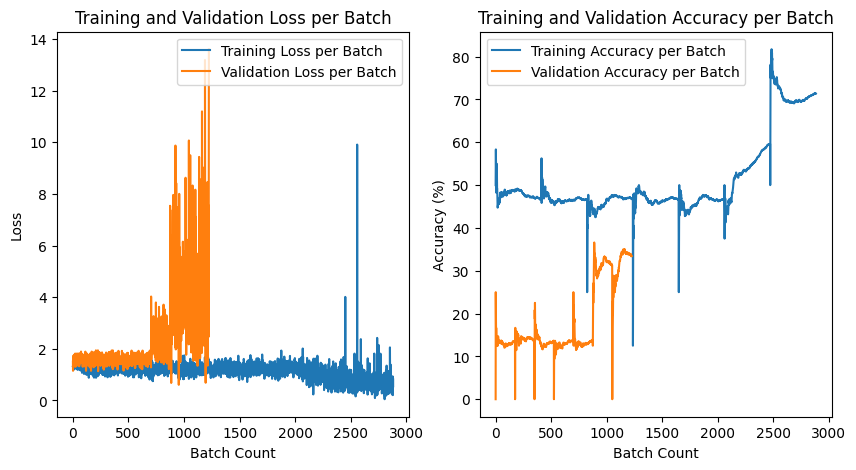

In [33]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_batch_losses, label='Training Loss per Batch')
plt.plot(val_batch_losses, label='Validation Loss per Batch')
plt.xlabel('Batch Count')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Batch')
plt.legend()

# Plotting batch-level training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_batch_accuracies, label='Training Accuracy per Batch')
plt.plot(val_batch_accuracies, label='Validation Accuracy per Batch')
plt.xlabel('Batch Count')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Batch')
plt.legend()

plt.show()

In [52]:
import matplotlib.pyplot as plt

train_batch_losses = []
train_batch_accuracies = []
val_batch_losses = []
val_batch_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    # Training loop with progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False) as pbar:
        for i, (flowpics, labels) in enumerate(pbar):
            # Move inputs and labels to the device (GPU or CPU)
            flowpics = flowpics.unsqueeze(1)  # add a channels dimension
            flowpics, labels = flowpics.to(device), labels.to(device).long()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(flowpics)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss and accuracy
            running_train_loss += loss.item() * flowpics.size(0)
            total_train_samples += flowpics.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()

            # Store batch-level training metrics
            train_batch_losses.append(loss.item())
            train_batch_accuracies.append((correct_train_predictions / total_train_samples) * 100)

    # Calculate epoch-level training loss and accuracy
    mean_train_loss = running_train_loss / total_train_samples
    mean_train_accuracy = (correct_train_predictions / total_train_samples) * 100

    # Validation loop with progress bar
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient computation for validation
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False) as pbar:
            for i, (flowpics, labels) in enumerate(pbar):
                # Move inputs and labels to the device (GPU or CPU)
                flowpics = flowpics.unsqueeze(1)  # add a channels dimension
                flowpics, labels = flowpics.to(device), labels.to(device).long()

                # Forward pass
                outputs = model(flowpics)
                loss = criterion(outputs, labels)

                # Accumulate validation loss and accuracy
                running_val_loss += loss.item() * flowpics.size(0)
                total_val_samples += flowpics.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()

                # Store batch-level validation metrics
                val_batch_losses.append(loss.item())
                val_batch_accuracies.append((correct_val_predictions / total_val_samples) * 100)

    # Calculate epoch-level validation loss and accuracy
    mean_val_loss = running_val_loss / total_val_samples
    mean_val_accuracy = (correct_val_predictions / total_val_samples) * 100

    # Print mean statistics for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Training - Mean Loss: {mean_train_loss:.4f}, Mean Accuracy: {mean_train_accuracy:.2f}%")
    print(f"  Validation - Mean Loss: {mean_val_loss:.4f}, Mean Accuracy: {mean_val_accuracy:.2f}%")

    # Plot and save the figure after each epoch
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation losses per batch
    plt.subplot(1, 2, 1)
    plt.plot(train_batch_losses, label='Training Loss per Batch')
    plt.plot(val_batch_losses, label='Validation Loss per Batch')
    plt.xlabel('Batch Count')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Batch')
    plt.legend()

    # Plot training and validation accuracies per batch
    plt.subplot(1, 2, 2)
    plt.plot(train_batch_accuracies, label='Training Accuracy per Batch')
    plt.plot(val_batch_accuracies, label='Validation Accuracy per Batch')
    plt.xlabel('Batch Count')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy per Batch')
    plt.legend()

    plt.suptitle(f'Epoch {epoch+1}/{num_epochs}')
    plt.savefig(f'training_progress_epoch_{epoch+1}.png')
    plt.close()


Epoch [1/7]
  Training - Mean Loss: 1.2608, Mean Accuracy: 44.47%
  Validation - Mean Loss: 1.6602, Mean Accuracy: 13.66%


Epoch [2/7]
  Training - Mean Loss: 1.2429, Mean Accuracy: 46.66%
  Validation - Mean Loss: 1.5963, Mean Accuracy: 13.66%


KeyboardInterrupt: 